In [1]:
import sys
sys.path.append("../src/models/")
sys.path.append("../src/")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from evaluate import Evaluator
import torch
from skimage import transform
import os, glob
from skimage import measure

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
unet_1 = "unet_firstbreak_noisetype_2_noisescale_2.0_dataclip_True_attack_none_pretrained_False.pkl"
unet_2 = "unet_firstbreak_noisetype_3_noisescale_2.0_dataclip_True_attack_none_pretrained_False.pkl"
rest_1 = "restormer_firstbreak_noisetype_2_noisescale_1.0_dataclip_True_attack_none_pretrained_True.pkl"
rest_2 = "restormer_firstbreak_noisetype_2_noisescale_2.0_dataclip_True_attack_none_pretrained_True.pkl"
swin_1 = "swin_firstbreak_noisetype_0_noisescale_1.0_dataclip_True_attack_none_pretrained_False.pkl"
################
unet_den = "unet_denoise_noisetype_3_noisescale_2.0_dataclip_True_attack_none_pretrained_False.pkl"
rest_den = "restormer_denoise_noisetype_2_noisescale_2.0_dataclip_True_attack_none_pretrained_False.pkl"
swin_den = "swin_denoise_noisetype_0_noisescale_1.0_dataclip_True_attack_none_pretrained_False.pkl"

In [5]:
eval_unet = Evaluator(weight_file=unet_2)
eval_rest = Evaluator(weight_file=rest_2)
eval_swin = Evaluator(weight_file=swin_1)

['unet', 'firstbreak']


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


['restormer', 'firstbreak']
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2


/home/makam0a/anaconda3/envs/transformer-new/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352616446/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


In [6]:
eval_unet_den = Evaluator(weight_file=unet_den)
eval_rest_den = Evaluator(weight_file=rest_den)
eval_swin_den = Evaluator(weight_file=swin_den)

['unet', 'denoise']


Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


['restormer', 'denoise']
['swin', 'denoise']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [7]:
METADATA = '../metadata/'
EVALDATA = os.path.join(METADATA, 'evaluation/')
REALDATA = '../realdata/'

In [8]:
### take only firts 900 timesteps, make synthetic and real data closer to each other
skip=900
x_ = np.load(REALDATA + 'preds_unet_0_4_.npy')[:skip]
y_ = np.load(REALDATA + 'preds_att_unet_0_4_.npy')[:skip].astype(x_.dtype)
labels_ = np.load(REALDATA + 'generated_unet_0_4_.npy')[0]/2021*1001

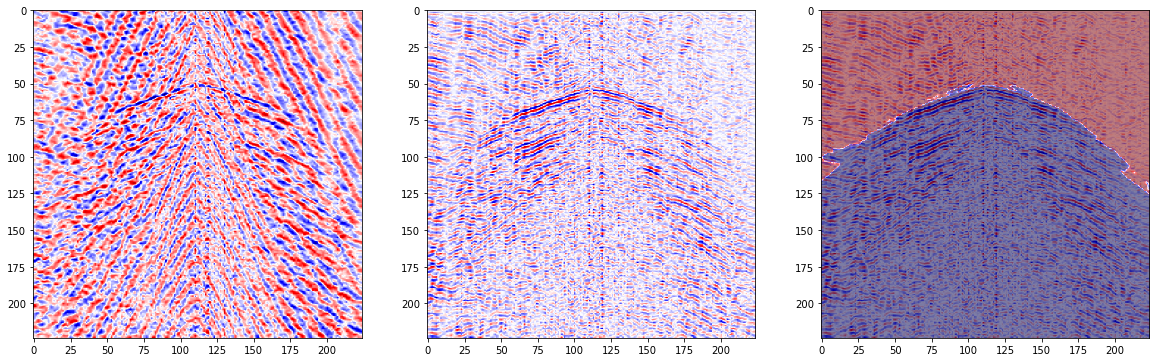

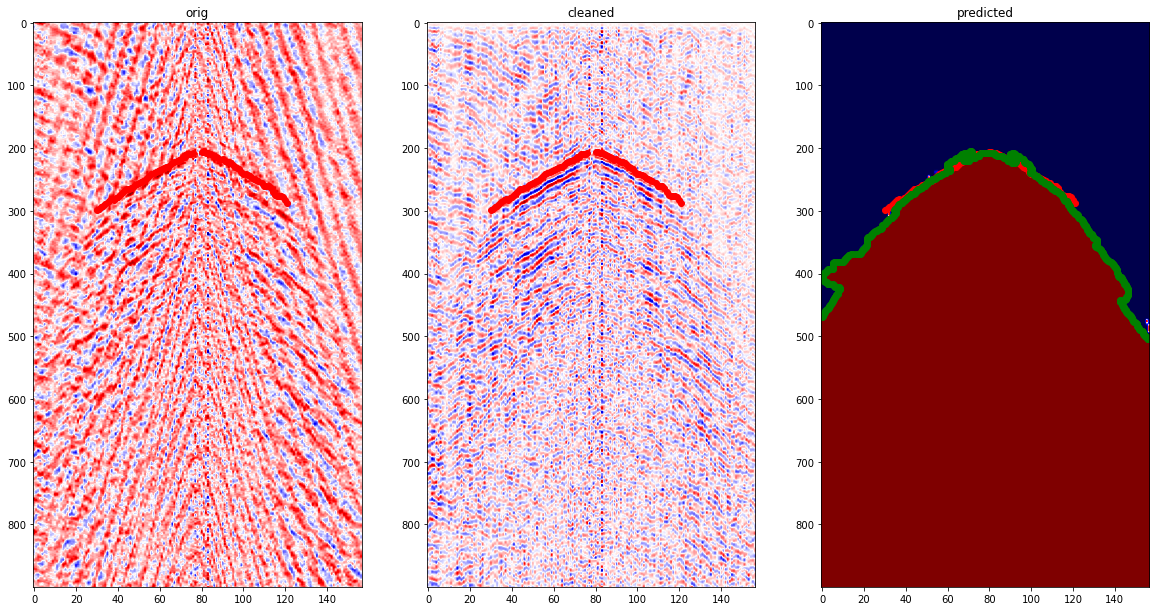

<Figure size 6000x3000 with 0 Axes>

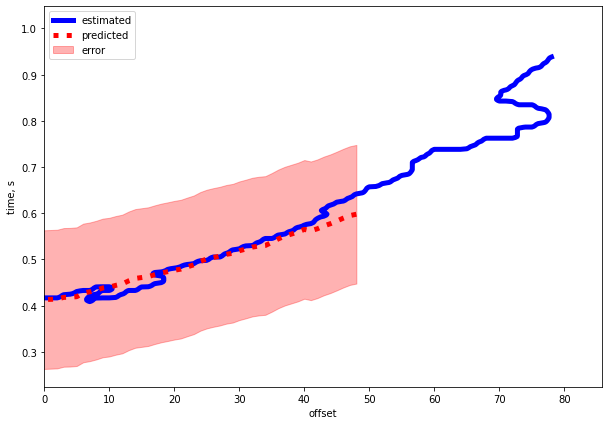

In [9]:
def plot_predictions(input_, pred_, target_, file=None):
    plt.figure(figsize=[20,20])
    plt.subplot(133)
    plt.imshow(pred_[0,0], cmap='seismic')
    plt.imshow(target_[0,0], cmap='seismic', alpha=0.5)
    plt.subplot(132)
    plt.imshow(target_[0,0], cmap='seismic')
    plt.subplot(131)
    plt.imshow(input_[0,0], cmap='seismic')
    if file is None:
        plt.show()
    else:
        plt.savefig(os.path.join(EVALDATA,'figures/','real/',file))
        plt.close()
        
def plot_predictions_orig(x_, pred, y_, file=None):
    ix, iy = x_.shape
    xx = np.arange(iy)
    mask = labels_ > 0
    plt.figure(figsize=[20,20])
    plt.subplot(131)
    plt.title('orig')
    plt.plot(xx[mask], labels_[mask], 'ro', lw=4)
    plt.imshow(x_, cmap='seismic', aspect=0.3)
    plt.subplot(132)
    plt.title('cleaned')
    plt.plot(xx[mask], labels_[mask], 'ro', lw=4)
    plt.imshow(y_, cmap='seismic', aspect=0.3)
    plt.subplot(133)
    plt.title('predicted')
    plt.plot(xx[mask], labels_[mask], 'ro', lw=4)
    contours = measure.find_contours(pred, 0.5)
    try:
        contour = sorted(contours,key= lambda x: len(x), reverse=True)[0]
        plt.plot( contour[:, 1], contour[:,0], 'go', lw=4)
    except IndexError:
        pass
    plt.imshow(pred, cmap='seismic', aspect=0.3)
    if file is None:
        plt.show()
    else:
        plt.savefig(os.path.join(EVALDATA,'figures/','real/', 'orig_' + file))
        plt.close()
        
def plot_offset(x_, label, *preds, file=None, dt=0.002):
    ix, iy = x_.shape
    xx = np.arange(iy)
    mask = labels_ > 0
    plt.figure(figsize=[20,10], dpi=300)
    center = iy//2
    plt.figure(figsize=[10,7])
    colors = ['b', 'r', 'g']
    for c, pred in zip(colors,preds):
        contours = measure.find_contours(pred, 0.5)
        contour = sorted(contours, key= lambda x: len(x), reverse=True)[0]
        plt.plot(center - contour[:, 1], dt*np.abs(contour[:, 0]), linewidth=5, c=c, label='estimated')
    plt.plot(center - xx[mask], dt*np.abs(labels_[mask]), c='r', ls=':',linewidth=5, label='predicted')
    plt.xlim(0)
    plt.xlabel("offset")
    plt.ylabel("time, s")
    plt.fill_between(center - xx[mask], dt*np.abs(labels_[mask]) - 0.15, dt*np.abs(labels_[mask]) + 0.15, alpha=0.3, color='r', label='error')
    plt.legend()
    if file is None:
        plt.show()
    else:
        plt.savefig(os.path.join(EVALDATA,'figures/','real/', 'offset_' + file))
        plt.close()
        

input_, pred_, target_ = eval_unet.predict_numpy(x_, y_)
pred = transform.resize(pred_[0].argmax(0), x_.shape, preserve_range=True).astype(pred_.dtype)
contours = measure.find_contours(pred, 0.5)
contour = sorted(contours, key= lambda x: len(x), reverse=True)[0]
plot_predictions(input_, pred_, target_)
plot_predictions_orig(x_, pred, y_)
plot_offset(x_, labels_, pred)

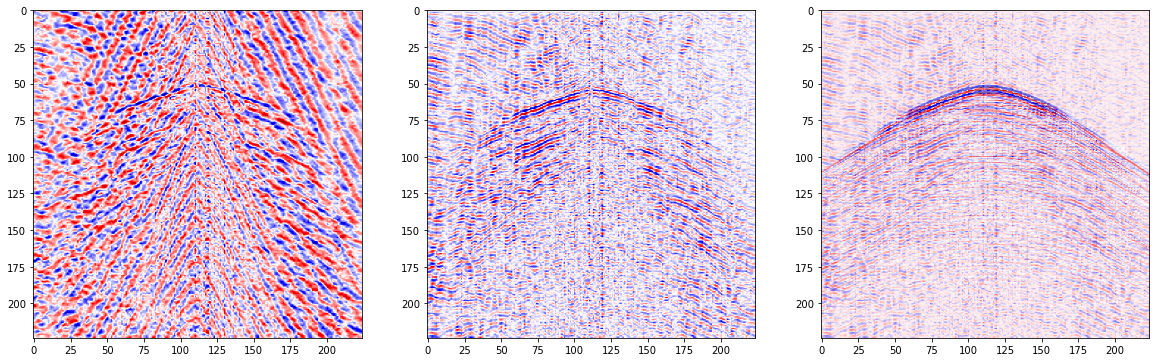

In [10]:
######################################
input_, pred_, target_ = eval_rest_den.predict_numpy(x_, y_)
plot_predictions(input_, pred_, target_)

In [11]:
######################################
input_, pred_, target_ = eval_unet.predict_numpy(x_, y_)
pred_unet = transform.resize(pred_[0].argmax(0), x_.shape, preserve_range=True).astype(pred_.dtype)
######################################
input_, pred_, target_ = eval_rest.predict_numpy(x_, y_)
pred_rest = transform.resize(pred_[0].argmax(0), x_.shape, preserve_range=True).astype(pred_.dtype)
######################################
input_, pred_, target_ = eval_swin.predict_numpy(x_, y_)
pred_swin = transform.resize(pred_[0].argmax(0), x_.shape, preserve_range=True).astype(pred_.dtype)
######################################

<Figure size 6000x3000 with 0 Axes>

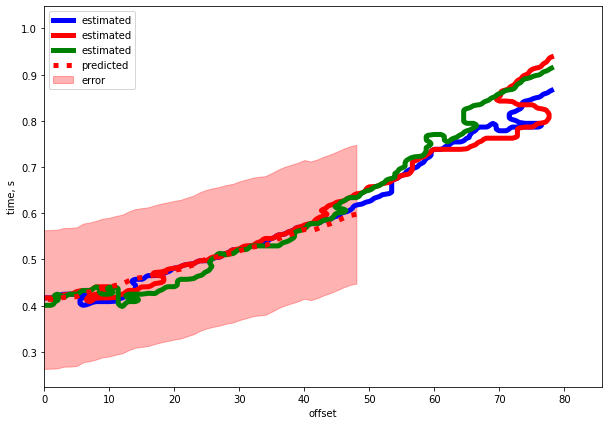

In [12]:
plot_offset(x_, labels_, pred_rest, pred_unet, pred_swin)

In [856]:
fnames = []
for model_type in ['swin_firstbreak']:
    fnames += glob.glob(os.path.join(METADATA, model_type) + '*')
    for fname in fnames:
        fname = os.path.basename(fname)
        print(f'Analysing {fname}')
        if not os.path.exists(os.path.join(METADATA, fname)):
            continue
        eval = Evaluator(fname)
        for i in range(2,6):
            x_ = np.load(REALDATA + f'preds_unet_0_{i}_.npy')[:skip]
            y_ = np.load(REALDATA + f'preds_att_unet_0_{i}_.npy')[:skip].astype(x_.dtype)
            labels_ = np.load(REALDATA + f'generated_unet_0_{i}_.npy')[0]/2021*1001
            input_, pred_, target_ = eval.predict_numpy(x_, y_)
            pred = transform.resize(pred_[0].argmax(0), x_.shape, preserve_range=True).astype(pred_.dtype)
            try:
                contours = measure.find_contours(pred, 0.5)
                contour = sorted(contours, key= lambda x: len(x), reverse=True)[0]
            except IndexError:
                continue
            plot_predictions(input_, pred_, target_, file=f"{fname[:-4]}_{i}.png")
            plot_predictions_orig(x_, pred, y_, file=f"{fname[:-4]}_{i}.png")
            plot_offset(x_, labels_, pred, file=f"{fname[:-4]}_{i}.png")

Analysing swin_firstbreak_noisetype_1_noisescale_0.5_dataclip_True_attack_none_pretrained_True.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_4_noisescale_1.0_dataclip_True_attack_fgsm_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_0_noisescale_0.5_dataclip_True_attack_fgsm_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_0_noisescale_1.0_dataclip_True_attack_none_pretrained_True.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 

/tmp/ipykernel_27491/1556047195.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[10,7])


Analysing swin_firstbreak_noisetype_1_noisescale_2.0_dataclip_True_attack_fgsm_pretrained_True (KW60784's conflicted copy 2022-08-12).pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---


/tmp/ipykernel_27491/1556047195.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[20,20])
/tmp/ipykernel_27491/1556047195.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[20,20])
/tmp/ipykernel_27491/1556047195.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figs

Analysing swin_firstbreak_noisetype_4_noisescale_1.0_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_0_noisescale_0.5_dataclip_True_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_5_noisescale_1.0_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_0_noisescale_1.0_dataclip_True_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2

Analysing swin_firstbreak_noisetype_1_noisescale_1.0_dataclip_True_attack_none_pretrained_True.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_3_noisescale_0.5_dataclip_True_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_4_noisescale_2.0_dataclip_True_attack_fgsm_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_0_noisescale_2.0_dataclip_True_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2,

Analysing swin_firstbreak_noisetype_1_noisescale_0.25_dataclip_True_attack_none_pretrained_True.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_3_noisescale_2.0_dataclip_True_attack_none_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_2_noisescale_2.0_dataclip_True_attack_fgsm_pretrained_False.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---
Analysing swin_firstbreak_noisetype_2_noisescale_1.0_dataclip_True_attack_fgsm_pretrained_True.pkl
['swin', 'firstbreak']
SwinTransformerSys expand initial----depths:[2, 2, 2,

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

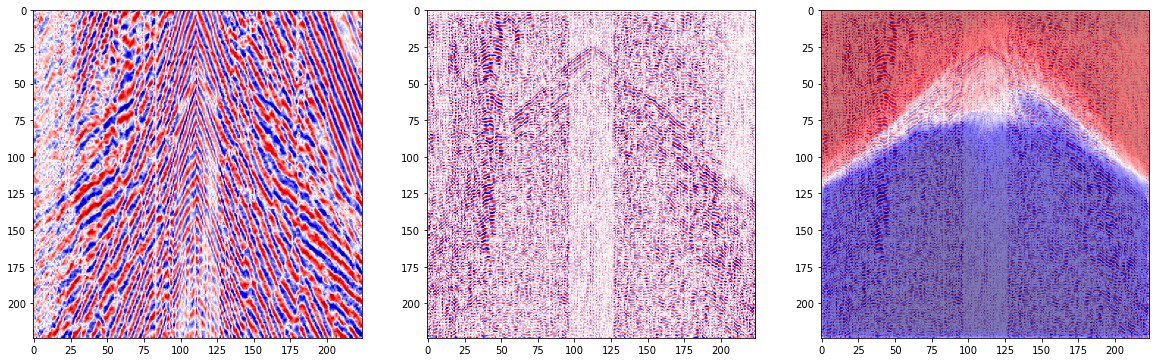

In [706]:
plt.figure(figsize=[20,20])
plt.subplot(133)
plt.imshow(pred_[0,0], cmap='seismic')
plt.imshow(target_[0,0], cmap='seismic', alpha=0.5)
plt.subplot(132)
plt.imshow(target_[0,0], cmap='seismic')
plt.subplot(131)
plt.imshow(input_[0,0], cmap='seismic')
plt.show()